In [39]:
# Load necessary packages:
import pandas as pd
import numpy as np
import json
import re
from pandas.io.json import json_normalize

In [ ]:
#########################################
#########################################
###### Read in the information for Sales 
#########################################
#########################################

In [2]:
# Read in the sales data
sales_csv =  pd.read_csv('../PMI/case 3/sales_granular.csv', sep = ',')

In [3]:
# To explore the sales data format
sales_csv.head(2)

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
0,10055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# number of unique stores in our sales data
len(sales_csv['store_code'].unique())

903

In [6]:
# Transposing data to a format easy to analyse and work with
df2 = pd.melt(sales_csv, id_vars=["store_code"], var_name="Date", value_name="SalesAmount")
### [TODO] check if this function performs correctly by multiplying matrice's rows and columns and comparing with the resulted number of rows

In [7]:
# The shape of the transposed sales data
print(df2.shape)
# number of records per store_code 
(df2["store_code"].value_counts()).to_frame().head(3)

(10814016, 3)


,store_code
11028,47744
32730,11936
19609,11936


In [8]:
# Dates without no actual purchase are not necessary 
# This results in reducing the size of data from 10814016 to 300 thousands
sales_not_zero = df2[df2["SalesAmount"] > 0].sort_index(by=['store_code'], ascending=[True])
print(sales_not_zero.shape)
sales_not_zero = sales_not_zero.reset_index(drop=True)
#sales_not_zero.head(2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


(299539, 3)

In [10]:
# To check for the opening times, we need Weekday and Hour information to be extracted from Date column
sales_not_zero['Date_dates'] = pd.to_datetime(sales_not_zero['Date'])
sales_not_zero['day_of_week'] = sales_not_zero['Date_dates'].dt.weekday_name
sales_not_zero['hour_of_day'] = sales_not_zero['Date_dates'].dt.hour
#sales_not_zero['year'] = sales_not_zero['Date_dates'].dt.year
#sales_not_zero['month'] = sales_not_zero['Date_dates'].dt.month

In [14]:
# The span of data
print( "min data is %s and max date is %s" % (min(sales_not_zero['Date_dates']), max(sales_not_zero['Date_dates'])))

min data is 2015-08-03 09:00:00 and max date is 2017-06-25 22:00:00


In [15]:
sales_not_zero.head(4)

,store_code,Date,SalesAmount,Date_dates,day_of_week,hour_of_day
10343286,249,5/29/17 13:00,30.0,2017-05-29 13:00:00,Monday,13
10767294,249,6/23/17 9:00,300.0,2017-06-23 09:00:00,Friday,9
7667868,249,12/20/16 10:00,30.0,2016-12-20 10:00:00,Tuesday,10
9087570,249,3/16/17 16:00,300.0,2017-03-16 16:00:00,Thursday,16


In [16]:
sales_not_zero.describe()

,store_code,SalesAmount,hour_of_day
count,299539.000000,299539.000000,299539.000000
mean,33074.090773,218.426148,13.597505
std,25680.552099,317.161511,3.758465
min,249.000000,30.000000,0.000000
25%,12667.000000,30.000000,11.000000
50%,21416.000000,90.000000,14.000000
75%,53584.000000,300.000000,17.000000
max,85011.000000,12750.000000,23.000000


In [41]:
##### we don't have holidays info, we can aggregate our data on weekday and hour and year for each store 
### This is useful as we will apply a heavy function on each of these rows
t = sales_not_zero[['store_code' ,'day_of_week' ,'hour_of_day', 'SalesAmount']]
df = t.groupby(['store_code', 'day_of_week' ,'hour_of_day']).sum().sum(
    level=['store_code', 'day_of_week' ,'hour_of_day']).reset_index()
df.head(3)

,store_code,day_of_week,hour_of_day,SalesAmount
0,249,Friday,9,360.0
1,249,Friday,10,900.0
2,249,Friday,11,300.0


In [18]:
#########################################
#########################################
###### Read in the information for surrounding shops 
#########################################
#########################################

In [19]:
data2 = pd.read_json('../PMI/case 3/Surroundings.json')

In [20]:
print(data2.head(2))
data2.shape

   store_code                                       surroundings
0       10055  {'subway_station': [], 'department_store': [],...
1       10077  {'subway_station': [], 'department_store': [],...


(546, 2)

In [ ]:
## Important: the surrounding amenities info is only available for 546 (almost 50%) of stores 

In [21]:
from pandas.io.json import json_normalize

In [22]:
# Total number of different types of amenities that can be found around each store
len(data2[data2["store_code"] == 10055]["surroundings"][0].keys())

89

In [30]:
### To flatten the JSON file
# For each row, all instances in each type of amenities, are extracted and converted to a dataframe with add. info 
### [TODO] A loop in Pandas is not a good practice, this piece of should be improved!
appended_data = pd.DataFrame()
keys = data2[data2["store_code"] == 10055]["surroundings"][0].keys()
for index , row in data2.iterrows(): 
    # To follow the progress, print index
    print(index)
    store_code = row['store_code']
    for key in keys:
        #print(store_code)
        #print(key)
        #print(row['surroundings'].get(key))
        if(row['surroundings'].get(key) !=  []):
            norm_surround_info = (json_normalize(row['surroundings'].get(key)))
            #print(type(norm_surround_info))
            norm_surround_info["shop_type"] = key
            norm_surround_info["store_code"] = store_code
            appended_data = appended_data.append(norm_surround_info)  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [31]:
## There are 82085 amenities of different types
appended_data.shape

(82085, 20)

In [32]:
# The resulted dataframe
appended_data.head(2)

,address_components,formatted_address,icon,international_phone_number,latitude,longitude,name,opening_hours,opening_hours.open_now,opening_hours.periods,opening_hours.weekday_text,place_id,price_level,rating,reviews,shop_type,store_code,types,user_ratings_total,website
0,"[{'long_name': '4', 'types': ['street_number']...","Rue de Genève 4, 1225 Chêne-Bourg, Switzerland",https://maps.gstatic.com/mapfiles/place_api/ic...,+41 22 788 79 69,46.195210,6.192416,"Jade Beaute, Nguyen",NaN,True,"[{'close': {'day': 1, 'time': '1800'}, 'open':...","[Monday: 9:00 AM – 6:00 PM, Tuesday: 9:00 AM –...",ChIJQX0xf_1vjEcRb3nniibfdv0,NaN,4.0,"[{'rating': 4, 'author_name': 'Eladia Ballmann...",beauty_salon,10055,"[beauty_salon, point_of_interest, establishment]",1.0,http://www.jadebeaute.com/
1,"[{'long_name': '5', 'types': ['street_number']...","Rue du Péage 5, 1225 Chêne-Bourg, Switzerland",https://maps.gstatic.com/mapfiles/place_api/ic...,+41 79 626 23 65,46.195151,6.191925,Onglerie Michèle,NaN,True,"[{'close': {'day': 1, 'time': '1800'}, 'open':...","[Monday: 10:00 AM – 6:00 PM, Tuesday: 10:00 AM...",ChIJpfgrh_1vjEcRg0Pib7g1uIE,NaN,NaN,NaN,beauty_salon,10055,"[hair_care, beauty_salon, point_of_interest, e...",NaN,NaN


In [58]:
## This function calcualtes information about surrounding amenities for a given store_code, in a given day and hour
def getShopsSurroundingOpen(store_code, weekday, hour):
    #rowsAppendedData = pd.DataFrame()
    #print("store_code %s ----- weekday %s ---- hour %s" % (store_code, weekday, hour))
    p = re.compile(r'\d+:\d\d')
    #weekday = 'Monday'
    #hour = '9:00'
    countOpenShopsAtPurchaseTime = 0
    resultsArray = {}
    resultsArray['countTotalOpenShops'] = 0 
    #countOpenShopsAtPurchaseTime 
    resultsArray['store_code'] = store_code
    resultsArray['day_of_week'] = weekday
    resultsArray['hour_of_day'] = hour
    resultsArray['Date_dates'] = Date_dates
    ### count open shop_type for each store, first set as zero
    for key in data2[data2["store_code"] == 10055]["surroundings"][0].keys():
        resultsArray[key] = 0
    #Surrounding shops for the store
    store_surrounding_shops = appended_data[appended_data['store_code'] == store_code]
    # Total number of shops around either close or open
    resultsArray['total_shops_around'] = store_surrounding_shops.shape[0]
    #Open surrounding shops
    openOnes = pd.DataFrame(store_surrounding_shops[store_surrounding_shops['opening_hours.open_now']!= 'False'])
    # Iterate over shops to check whether open the in time of purchase
    for index, rows in openOnes.iterrows():
        ifShopOpen = False;
        #print(rows)
        openCloseDates = rows['opening_hours.weekday_text']
        shop_type = rows['shop_type']
        #print(openCloseDates)
        # Iterate over opening time/days
        if pd.isnull(openCloseDates) is not True:
            # check the day
            for day in openCloseDates:
                day = str(day)
                if weekday in str(day): 
                    #print(day)
                    # find hours in the time schedule of the day
                    res = re.findall(p , day)
                    if(res):
                        (h1, m1) = [int(x) for x in res[0].split(":")]
                        (h2, m2) = [int(x) for x in res[1].split(":")]
                        h2 = h2 + 12
                        #print(hour) => 9
                        #(h3, m3) = [int(x) for x in hour.split(":")]
                        # there are no minutes in the given sales hour
                        m3 = 0
                        #print(res[0])
                        #print(res[1])
                        if (h1) <= (hour) and hour <= h2 and (m1) <= (m3) and m3 <= m2:
                            #countOpenShopsAtPurchaseTime += 1
                            ifShopOpen = True;
                            #if(shop type)
                            #print("yes")
            if ifShopOpen is True:
                resultsArray[shop_type] = resultsArray[shop_type] + 1
                resultsArray['countTotalOpenShops'] = resultsArray['countTotalOpenShops'] + 1 
                #countOpenShopsAtPurchaseTime 
        #rowsAppendedData.append(pd.DataFrame(resultsArray))
        #print("resultsArray size is %s -----------------------" % len(resultsArray))
    return resultsArray

In [47]:
# To keep df safe, and from changes
df_copy_sales = df
# Get information about (open) surrounding stores to each purrchase row (being open depends on the hour of purchase) 
lambdafunc = lambda x: getShopsSurroundingOpen(x['store_code'], x['day_of_week'], x['hour_of_day'])
newcols = df_copy_sales.apply(lambdafunc, axis=1)
#newcols.columns = ['hour', 'weekday', 'weeknum']


In [569]:
#########################################
#########################################
###### Join sales and surrounding amenities data 
#########################################
#########################################

In [146]:
# Join the sales data with the open amenities data
s = newcols.tolist()
newcols_df = pd.DataFrame(s, columns = newcols.iloc[0].keys())
#df_copy_sales IS THE sales data
#newcols_df is the list of opem shops for a store
new_df = pd.merge(df_copy_sales, newcols_df,  how='left', left_on=['store_code','day_of_week', 'hour_of_day'], right_on = ['store_code','day_of_week', 'hour_of_day'])

In [578]:
### The resulted dataframe that we will run our analysis on.
new_df[new_df['countTotalOpenShops']>0].tail(3)

,store_code,day_of_week,hour_of_day,SalesAmount,countTotalOpenShops,subway_station,department_store,embassy,beauty_salon,police,...,train_station,fire_station,laundry,insurance_agency,plumber,pet_store,bakery,travel_agency,total_shops_around,High_Low_Sales
39659,47724,Wednesday,15,30.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0
39660,47724,Wednesday,18,180.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0
39661,47724,Wednesday,19,120.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0


In [568]:
df_count_purchasesPerTotalOpenAmens = pd.DataFrame(new_df['countTotalOpenShops'].value_counts().reset_index())
df_count_purchasesPerTotalOpenAmens.columns = ['countTotalOpenAmenities' , '# of Purchases']
df_count_purchasesPerTotalOpenAmens.head(5)
#df_count_purchasesPerTotalOpenAmens.plot.bar('countTotalOpenAmenities', '# of Purchases', align='center', alpha=0.5, figsize=(15, 6), 
#            title = '# Purchases by Number of Open Surrounding Amenities')
# 0      25382 of total sales have no open shops around them 

,countTotalOpenAmenities,# of Purchases
0,0,25382
1,2,906
2,6,745
3,4,613
4,7,561


In [ ]:
### [TODO] we could remove the stores that are not in the list of surrounding amenities database in the json file
## Could result in more efficient run of the code

In [132]:
# total sales with at least, one shop open
new_df[new_df['countTotalOpenShops'] > 0]['SalesAmount'].sum()

11758830.0

In [133]:
# Total sales when there is no open shop around
new_df[new_df['countTotalOpenShops'] == 0]['SalesAmount'].sum()

53668320.0

In [166]:
# Calculate percentage of sales when at least one shop is around
new_df[new_df['total_shops_around'] > 0]['SalesAmount'].sum() / new_df['SalesAmount'].sum()

0.1821184324855966

In [135]:
new_df[new_df['total_shops_around']== 0]['SalesAmount'].sum()

53511660.0

In [570]:
#########################################
#########################################
###### regression model
#########################################
#########################################
# Approach: 
# Model: 
# Accuracy approach: 

In [306]:
# Import packages for the modeling part
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [299]:
## Use the Sales data with at least one surrounding open shops 
# As we focus on studying which type of amenity has more influence, data with no info on this can be ignored
new_df_q = new_df[new_df['total_shops_around'] > 0]

In [300]:
#day_of_week is String, should be converted to numbers
days ={'Monday' : 1, 'Tuesday' : 2, 'Wednesday': 3, 'Thursday': 4, 'Friday' : 5, 'Saturday':  6, 'Sunday': 7}
lambdafuncdaynum = lambda x: days[x]
new_df_q['day_of_week'] = new_df_q['day_of_week'].apply(lambdafuncdaynum)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [301]:
### [TODO] shorten this cell

### Define the features for the model
# new_df_q.columns -> gives a list of all columns

# We remove countTotalOpenShops , 'SalesAmount', 'total_shops_around', 'store_code', 'day_of_week', 'hour_of_day'

feature_headers = [ 
        'subway_station', 'department_store', 'embassy',
       'beauty_salon', 'police', 'courthouse', 'cemetery', 'pharmacy',
       'local_government_office', 'shopping_mall', 'city_hall', 'rv_park',
       'shoe_store', 'bank', 'bowling_alley', 'bar', 'university',
       'car_dealer', 'movie_theater', 'taxi_stand', 'jewelry_store', 'church',
       'convenience_store', 'campground', 'lawyer', 'parking', 'post_office',
       'hindu_temple', 'hardware_store', 'meal_takeaway', 'movie_rental',
       'gas_station', 'funeral_home', 'aquarium', 'restaurant',
       'home_goods_store', 'casino', 'veterinary_care', 'airport',
       'bus_station', 'museum', 'night_club', 'electrician', 'mosque',
       'amusement_park', 'lodging', 'florist', 'liquor_store', 'hospital',
       'car_rental', 'stadium', 'store', 'hair_care', 'transit_station',
       'meal_delivery', 'gym', 'park', 'dentist', 'library', 'book_store',
       'painter', 'roofing_contractor', 'moving_company', 'clothing_store',
       'furniture_store', 'physiotherapist', 'atm', 'art_gallery', 'car_wash',
       'locksmith', 'spa', 'accounting', 'cafe', 'car_repair', 'synagogue',
       'real_estate_agency', 'electronics_store', 'doctor', 'bicycle_store',
       'storage', 'zoo', 'train_station', 'fire_station', 'laundry',
       'insurance_agency', 'plumber', 'pet_store', 'bakery', 'travel_agency']

In [302]:
# This ca be removed. We used all the data
X_train, X_test, y_train, y_test = train_test_split(new_df_q[feature_headers], new_df_q['SalesAmount'], train_size=0.7)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [328]:
model = sm.OLS(new_df_q['SalesAmount'], new_df_q[feature_headers])
results = model.fit()
print(results.summary())            

                            OLS Regression Results                            
Dep. Variable:            SalesAmount   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     323.9
Date:                Sun, 14 Jan 2018   Prob (F-statistic):               0.00
Time:                        21:36:21   Log-Likelihood:            -1.8818e+05
No. Observations:               21805   AIC:                         3.765e+05
Df Residuals:                   21723   BIC:                         3.772e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
subway_station           2

In [526]:
### We use coefficients and pvalues of each feature to find the most important and effective one 
df_pv = pd.Series.to_frame(results.pvalues)
df_pv = df_pv.reset_index()
df_pv.columns = ['param', 'pvalue']
df_pv.head(2)

,param,pvalue
0,subway_station,9.789481e-01
1,department_store,3.025740e-115


10703.4697602


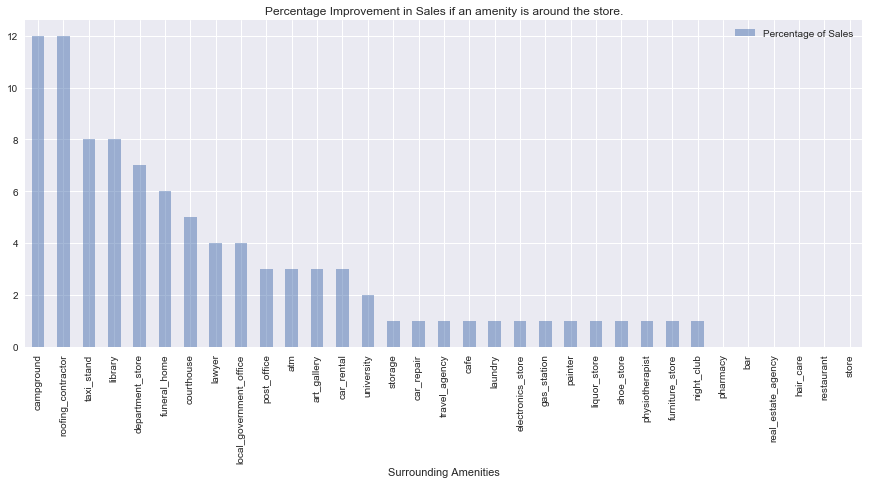

In [552]:
### The higher the coefficient the more effective
T1 = pd.Series.to_frame(results.params[results.params > 0].sort_values(ascending=False)).reset_index()
T1.columns = ['param', 'coef_value']
print(sum(T1['coef_value']))
T2 = pd.merge(T1, df_pv, how='left', on=['param'])
### To select statisticcally significant parameters
T2 = T2[T2['pvalue'] < 0.05]
T2['coef_perc'] = round(T2['coef_value']/(sum(T1['coef_value']))*100)
T2.columns = ['Surrounding Amenities', 'coef_value', 'pvalue', 'Percentage of Sales']
T2.plot.bar('Surrounding Amenities', 'Percentage of Sales', align='center', alpha=0.5, figsize=(15, 6), 
            title = 'Percentage Improvement in Sales if an amenity is around the store.'
           )

In [574]:
###########Not used and not reported therefore############
#########################################
###### Classification approach to define a list of most important features
#########################################
#########################################
# Approach: Label data, fit a random forest model, get the path and Gini values
# Model: ElasticNetCV
# Accuracy approach: confusion matrix

In [575]:
# define what is high and what is low in sells
average_sale_by_shop = round(new_df['SalesAmount'].sum() / new_df['SalesAmount'].shape[0])
lambdafunc = lambda x: 1 if (x['SalesAmount'] > average_sale_by_shop) else 0
new_df['High_Low_Sales'] = new_df.apply(lambdafunc, axis=1)

In [227]:
X_train, X_test, y_train, y_test = train_test_split(new_df_q[feature_headers], new_df_q['High_Low_Sales'], train_size=0.7)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [252]:
#clf = RandomForestClassifier()
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
clf.fit(X_train, y_train)
predictions  = clf.predict(X_test)
# Train and Test Accuracy
print("Train Accuracy   ::  %s" %  accuracy_score(y_train, clf.predict(X_train)))
print("Test Accuracy    ::  %s" %  accuracy_score(y_test, predictions))
print("Confusion matrix ::  %s" %  confusion_matrix(y_test, predictions))

Train Accuracy   ::  1.0
Test Accuracy    ::  0.996942830939
Confusion matrix ::  [[6054    3]
 [  17  468]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3

Feature ranking:
1.	 feature 3 	 (0.587045) SalesAmount
2.	 feature 0 	 (0.071752) store_code
3.	 feature 94 	 (0.029073) total_shops_around
4.	 feature 25 	 (0.022786) jewelry_store
5.	 feature 4 	 (0.019952) countTotalOpenShops
6.	 feature 54 	 (0.019480) car_rental
7.	 feature 2 	 (0.016456) hour_of_day
8.	 feature 39 	 (0.015535) restaurant
9.	 feature 92 	 (0.014831) bakery
10.	 feature 77 	 (0.013955) cafe
11.	 feature 40 	 (0.009736) home_goods_store
12.	 feature 1 	 (0.009120) day_of_week
13.	 feature 29 	 (0.008772) lawyer
14.	 feature 34 	 (0.008409) meal_takeaway
15.	 feature 88 	 (0.007337) laundry
16.	 feature 56 	 (0.007284) store
17.	 feature 46 	 (0.007046) night_club
18.	 feature 57 	 (0.006657) hair_care
19.	 feature 31 	 (0.006458) post_office
20.	 feature 14 	 (0.006288) shopping_mall
21.	 feature 60 	 (0.005516) gym
22.	 feature 64 	 (0.005455) book_store
23.	 feature 63 	 (0.005188) library
24.	 feature 68 	 (0.004898) clothing_store
25.	 feature 62 	 (0.004662) d

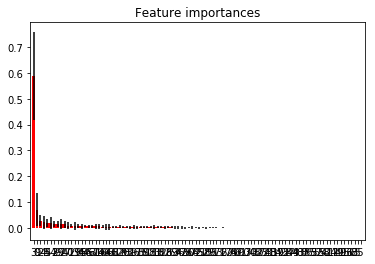

In [280]:
import matplotlib.pyplot as plt
forest = clf
X = new_df_q

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0, X.shape[1]-1):
    print("%d.\t feature %d \t (%f) %s" % (f + 1, indices[f], importances[indices[f]], feature_headers[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]-1), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [378]:
#######################
#########################################
###### Plot the sales for a store
#########################################
#########################################

In [471]:
ts = sales_not_zero
#ts['Date_dates'] = ts['Date_dates'].dt.date
ts = ts[['store_code', 'Date_dates', 'SalesAmount']]
ts = ts.groupby(['store_code', 'Date_dates']).sum().sum(
    level=['store_code', 'Date_dates']).reset_index()
ts_avg_stores = ts[['Date_dates', 'SalesAmount']]
ts_avg_stores = ts_avg_stores.groupby(['Date_dates']).sum().sum(
    level=['Date_dates']).reset_index()
ts_avg_stores['Date_dates'] = pd.to_datetime(ts_avg_stores['Date_dates'])
ts_avg_stores = ts_avg_stores.set_index('Date_dates')
ts_avg_stores.head(2)

,SalesAmount
Date_dates,
2015-08-03,10800.0
2015-08-04,18360.0


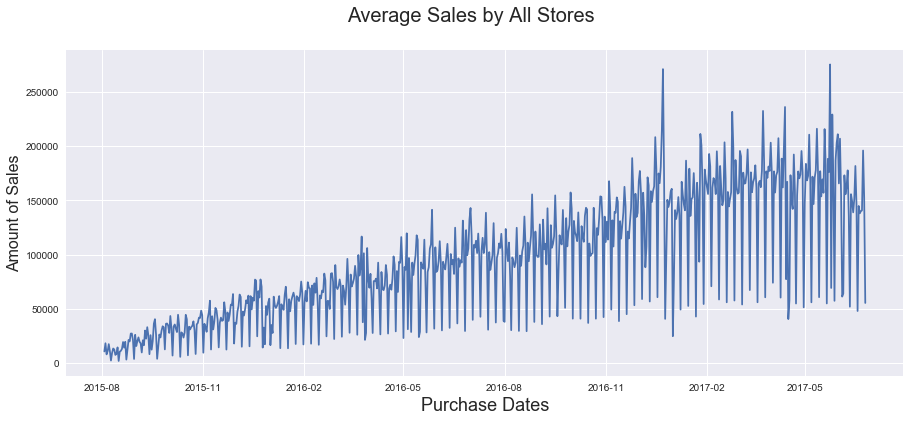

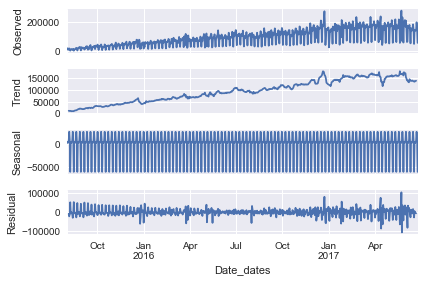

In [476]:
import statsmodels.api as sm
fig = plt.figure(figsize=(15, 6))
plt.plot(ts_avg_stores)
fig.suptitle('Average Sales by All Stores', fontsize=20)
plt.xlabel('Purchase Dates', fontsize=18)
plt.ylabel('Amount of Sales', fontsize=16)

decomposition = sm.tsa.seasonal_decompose(ts_avg_stores, model='additive')
fig = decomposition.plot()
#ts_avg_stores.plot(figsize=(15, 6))
plt.show()